In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform


## Первичная обработка данных

In [2]:
X = pd.read_excel('data/X_4_14.xlsx', names=[f'feature_{i}' for i in range(4)])
# Y = pd.read_excel('data/Y_4_14.xlsx', header=None)

In [3]:
X.describe()

,feature_0,feature_1,feature_2,feature_3
count,199.000000,199.000000,199.000000,199.000000
mean,2.989366,0.978693,3.042654,-0.053288
std,2.667961,1.193916,2.627396,1.657722
min,-1.770611,-1.098890,-1.686545,-3.001601
25%,0.950759,0.094083,1.015519,-1.329454
50%,3.036132,1.012075,2.999677,0.001223
75%,5.021846,1.939613,5.048610,1.153452
max,7.684823,3.085918,8.097899,3.110166


#### Проверка на выбросы

In [4]:
X.isna().sum()

feature_0    0
feature_1    0
feature_2    0
feature_3    0
dtype: int64

<Axes: >

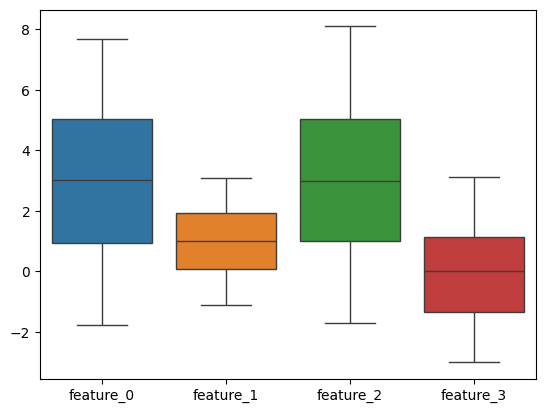

In [5]:
sns.boxplot(X)

<Axes: >

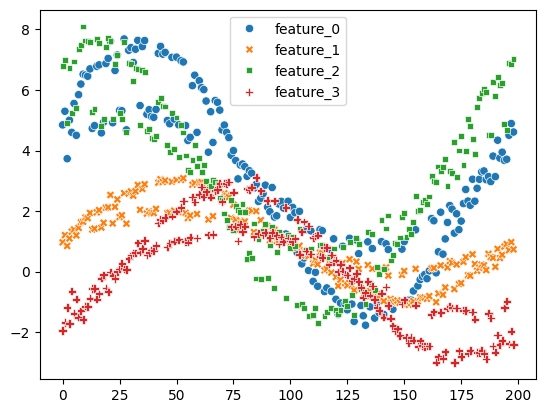

In [6]:
sns.scatterplot(X)

In [7]:
X = MinMaxScaler().fit_transform(X)

<Axes: >

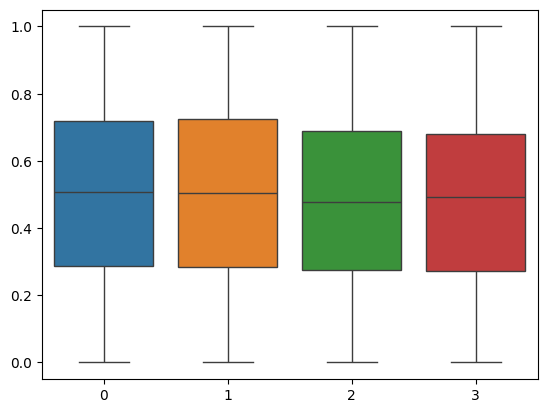

In [8]:
sns.boxplot(X)

## Подготовка данных

#### Вычисление матрицы расстояний

In [9]:
def get_dist_matrix(matrix, metric='euclidean'):
    if metric == 'minkowski':
        dist_vector = pdist(matrix, metric=metric, p=4)
    else:
        dist_vector = pdist(matrix, metric=metric)
    return squareform(dist_vector)

In [10]:
d_matrix_euclidean = get_dist_matrix(X, metric='euclidean')

#### Вычисление similarity-матрицы 

In [11]:
def get_similarity_matrix(d_matrix):
    sim_matrix = 1 / (1 + d_matrix)
    return sim_matrix

In [12]:
sim_matrix = get_similarity_matrix(d_matrix_euclidean)

In [13]:
sim_matrix

array([[1.        , 0.91946186, 0.7951142 , ..., 0.90640979, 0.98974981,
        0.90863589],
       [0.91946186, 1.        , 0.77365003, ..., 0.84300768, 0.92126408,
        0.84814405],
       [0.7951142 , 0.77365003, 1.        , ..., 0.77242397, 0.78862048,
        0.76426009],
       ...,
       [0.90640979, 0.84300768, 0.77242397, ..., 1.        , 0.90749117,
        0.9814644 ],
       [0.98974981, 0.92126408, 0.78862048, ..., 0.90749117, 1.        ,
        0.91126384],
       [0.90863589, 0.84814405, 0.76426009, ..., 0.9814644 , 0.91126384,
        1.        ]])

<Axes: >

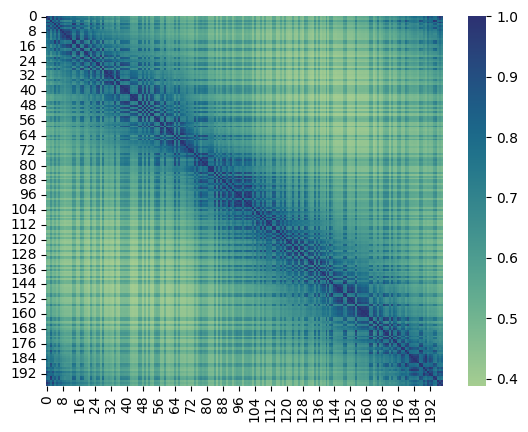

In [14]:
sns.heatmap(sim_matrix, cmap="crest")

Таким образом мы перешли к графовой модели, представленной матрицей схожести. Наблюдения из начальной таблицы стали вершинами графа, а схожесть наблюдений с индексами i и j - ребрами. Значение элемента [i, j] матрицы sim_matrix является весов ребра в нашем графе.

## Кластеризация для числа кластеров k=2

#### Кластеризация методом MST

Для кластеризации этим методом мы используем библиотеку networkx. Мы инициализируем граф и находим для него MST с помощью метода maximum_spanning_tree из этой библиотеки. Этот метод использует алгоритм Краскала для нахождения MST.

<Figure size 800x600 with 0 Axes>

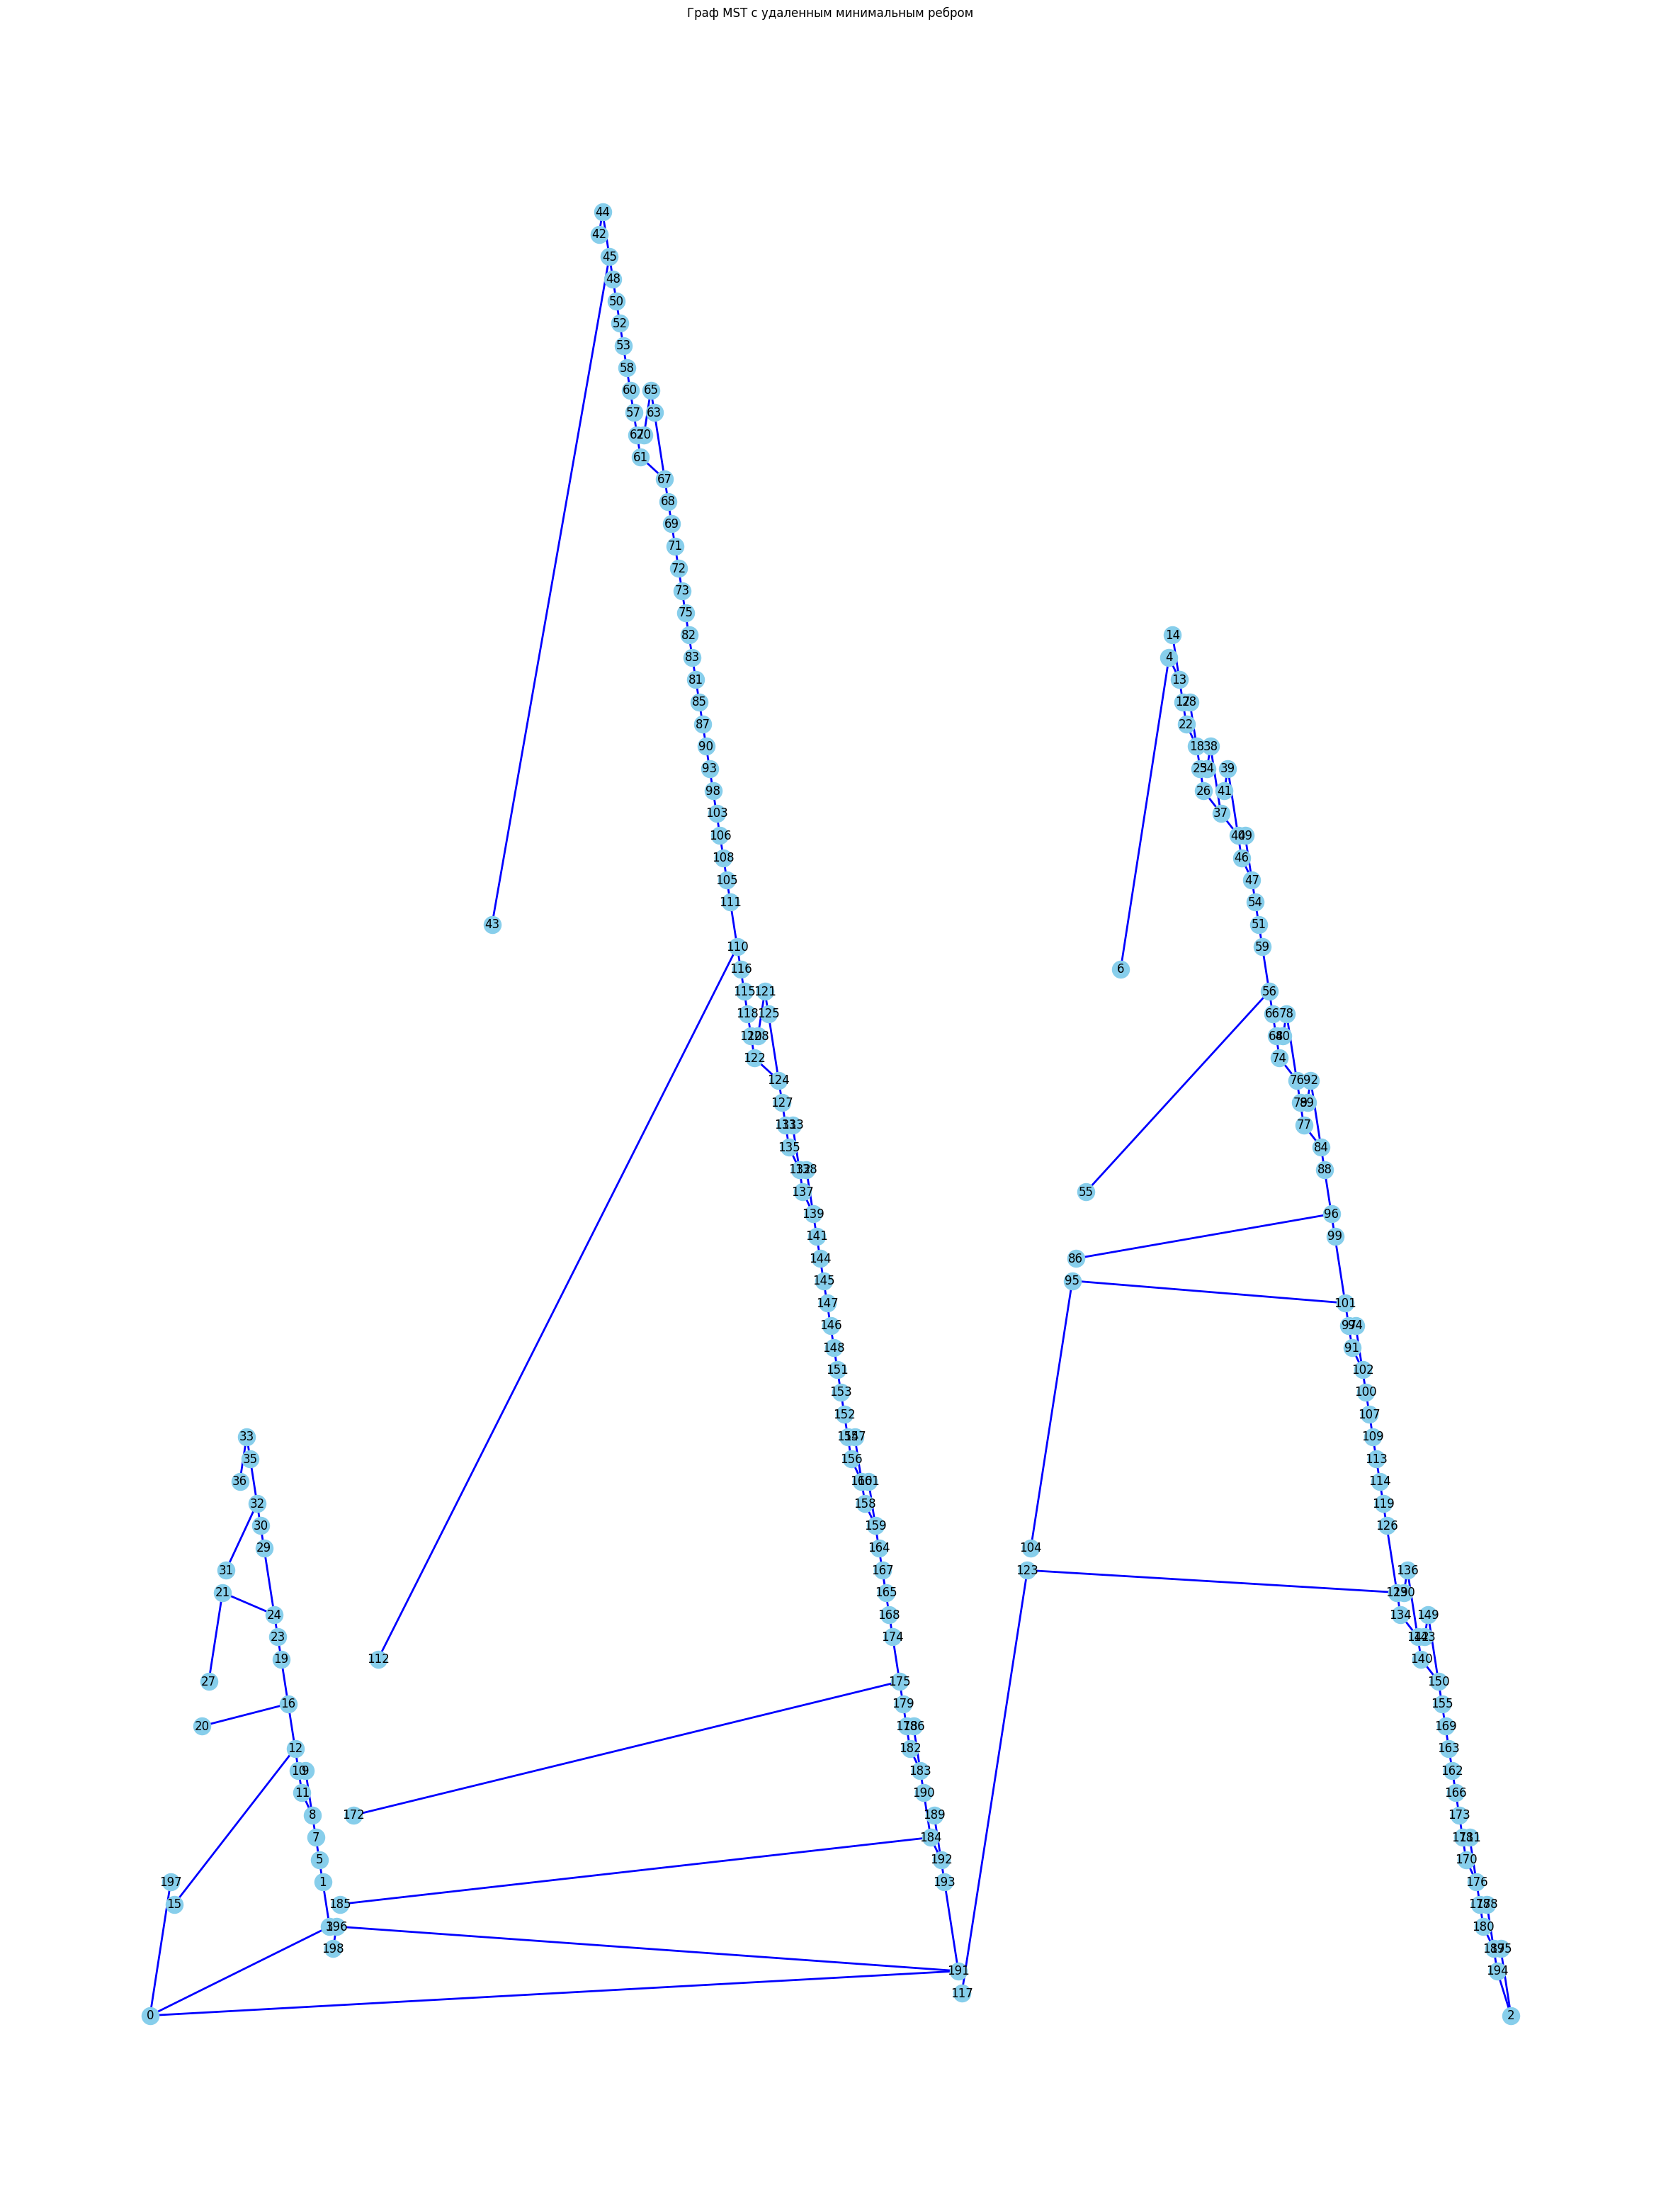

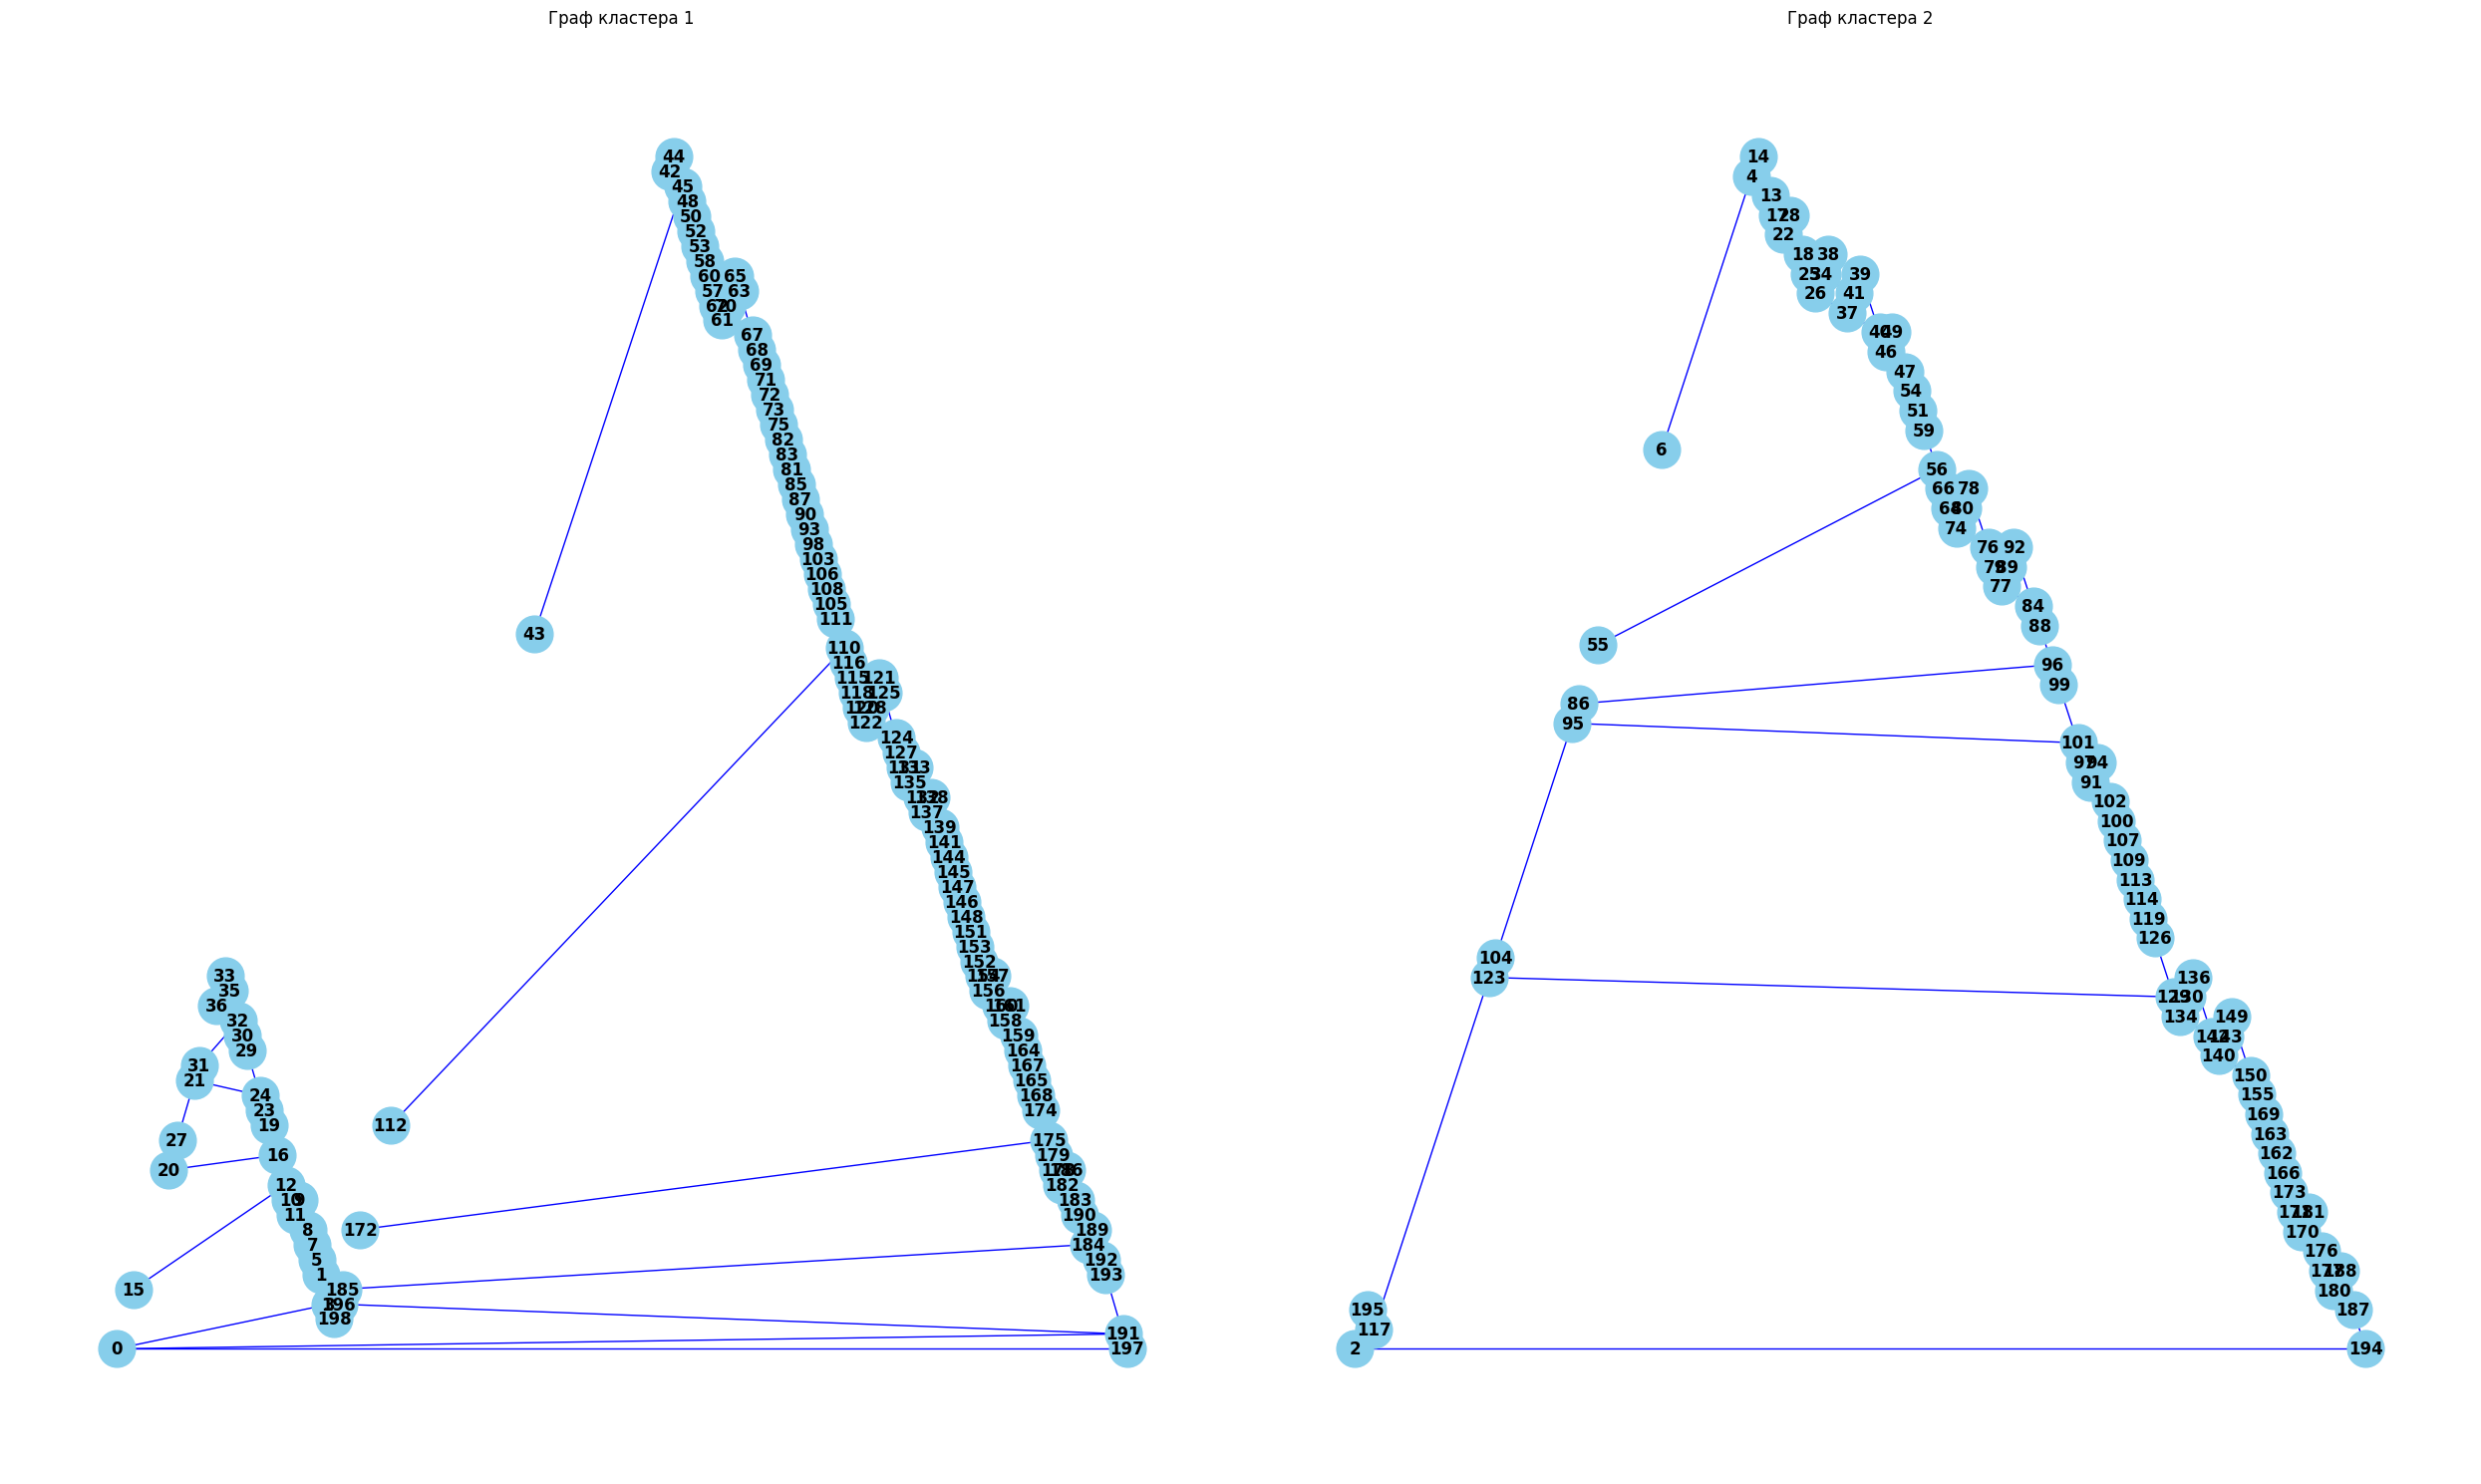

Кластер 1: [0, 1, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 19, 20, 21, 23, 24, 27, 29, 30, 31, 32, 33, 35, 36, 42, 43, 44, 45, 48, 50, 52, 53, 57, 58, 60, 61, 62, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 81, 82, 83, 85, 87, 90, 93, 98, 103, 105, 106, 108, 110, 111, 112, 115, 116, 118, 120, 121, 122, 124, 125, 127, 128, 131, 132, 133, 135, 137, 138, 139, 141, 144, 145, 146, 147, 148, 151, 152, 153, 154, 156, 157, 158, 159, 160, 161, 164, 165, 167, 168, 172, 174, 175, 178, 179, 182, 183, 184, 185, 186, 189, 190, 191, 192, 193, 196, 197, 198]
Кластер 2: [2, 4, 6, 13, 14, 17, 18, 22, 25, 26, 28, 34, 37, 38, 39, 40, 41, 46, 47, 49, 51, 54, 55, 56, 59, 64, 66, 74, 76, 77, 78, 79, 80, 84, 86, 88, 89, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 104, 107, 109, 113, 114, 117, 119, 123, 126, 129, 130, 134, 136, 140, 142, 143, 149, 150, 155, 162, 163, 166, 169, 170, 171, 173, 176, 177, 180, 181, 187, 188, 194, 195]


In [15]:
G = nx.Graph()
num_points = X.shape[0]

# Добавляем узлы
G.add_nodes_from(range(num_points))

# Добавляем рёбра с весами
for i in range(num_points):
    for j in range(i + 1, num_points):
        G.add_edge(i, j, weight=sim_matrix[i, j])

# Построение максимального остовного дерева (MST) алгоритмом Краскала
mst = nx.maximum_spanning_tree(G)

# Удаление самого короткого ребра
sorted_edges = sorted(mst.edges(data=True), key=lambda x: x[2]['weight'])
shortest_edge = sorted_edges[0]  # самое короткое ребро
mst.remove_edge(shortest_edge[0], shortest_edge[1])

# Получаем компоненты связности
clusters_mst = list(nx.connected_components(mst))

# Визуализация
plt.figure(figsize=(8, 6))

# Рисуем MST
plt.figure(figsize=(30, 40))
plt.title('Граф MST с удаленным минимальным ребром')
nx.draw_planar(mst, node_color="skyblue", edge_color="blue", with_labels=True, width=2)
plt.show()

plt.figure(figsize=(25, 15))

for i, cluster in enumerate(clusters_mst, start=1):
    subgraph = mst.subgraph(cluster)  # Создаём подграф для кластера

    plt.subplot(1, 2, i)
    nx.draw_planar(
        subgraph, with_labels=True, 
        node_color="skyblue", edge_color="blue", 
        node_size=700, font_weight="bold"
    )
    plt.title(f'Граф кластера {i}')
    plt.xlabel('X')
    plt.ylabel('Y')

plt.tight_layout()
plt.show()

for i, cluster in enumerate(clusters_mst, start=1):
    print(f"Кластер {i}: {sorted(cluster)}")

#### Кластеризация методом K-Means

In [16]:
kmeans = KMeans(n_clusters=2, n_init=50)
kmeans.fit(X)
labels = kmeans.predict(X)
cluster1 = np.arange(0, 199)[labels==1]
cluster2 = np.arange(0, 199)[labels==0]
clusters_kmeans = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_kmeans, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [86, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]
Кластер 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 92, 191, 194, 195, 196, 197, 198]


Кластеризация EM-алгоритмом

In [17]:
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=54)
gmm.fit(X)
labels = gmm.predict(X)
cluster1 = np.arange(0, 199)[labels==1]
cluster2 = np.arange(0, 199)[labels==0]
clusters_em = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_em, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [84, 86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


Кластеризация Unnormalized Spectral методом

In [18]:
W = sim_matrix
D = np.diag(W.sum(axis=1))
L = D - W

In [19]:
eig_vals, eig_vecs = np.linalg.eigh(L)
eig_vecs_2 = eig_vecs[:, :2]
kmeans = KMeans(n_clusters=2, n_init=50)
labels = kmeans.fit_predict(eig_vecs_2)
cluster1 = np.arange(0, 199)[labels==1]
cluster2 = np.arange(0, 199)[labels==0]
clusters_spectral = [set(cluster1), set(cluster2)]
for i, cluster in enumerate(clusters_spectral, start=1):
    print(f"Кластер {i}: {sorted(list(map(lambda x: int(x), cluster)))}")

Кластер 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 89, 92, 191, 194, 195, 196, 197, 198]
Кластер 2: [86, 88, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 192, 193]


Сравнение разбиений попарно

In [20]:
def count_pairs_disjoin(left_set: set, right_sets: list[set]):
    left_set_pairs_cnt = len(left_set)*(len(left_set)-1)
    
    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt - len(separation)*(len(separation)-1)

    return left_set_pairs_cnt

def count_pairs_join(left_set: set, right_sets: list[set]):
    left_set_pairs_cnt = 0
    
    for rs in right_sets:
        separation = left_set.intersection(rs)
        left_set_pairs_cnt = left_set_pairs_cnt + len(separation)*(len(separation)-1)

    return left_set_pairs_cnt

def get_rand_index(part1: list[set], part2: list[set]):
    left_sets = part1
    right_sets = part2
    
    left_pair_union = sum([count_pairs_join(x, right_sets) for x in left_sets])
    right_pair_union = sum([count_pairs_join(x, left_sets) for x in right_sets])

    union_cnt = left_pair_union + right_pair_union

    left_pair_diff = sum([count_pairs_disjoin(x, right_sets) for x in left_sets])
    right_pair_diff = sum([count_pairs_disjoin(x, left_sets) for x in right_sets])

    diff_cnt = left_pair_diff + right_pair_diff

    return union_cnt/(union_cnt+diff_cnt)

In [42]:
import random 
def r_partition(n_parts, edges):
    idxs = list(range(0, edges))
    random.shuffle(idxs)
    return [set(idxs[i::n_parts]) for i in range(n_parts)]

In [45]:
rand_idx_matrix = np.zeros((5,5))

for i, m1 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    for j, m2 in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
        rand_idx_matrix[i,j] = get_rand_index(m1, m2)
    
rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50410739, 0.        ],
       [0.5037594 , 1.        , 0.97005805, 0.97992664, 0.        ],
       [0.50445579, 0.97005805, 1.        , 0.98992469, 0.        ],
       [0.50410739, 0.97992664, 0.98992469, 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ]])

In [46]:
random_partitions = [r_partition(2, 199) for i in range(1000)]

In [47]:
for i, m in enumerate([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral]):
    mean_rand_idx_vs_randompart = sum([get_rand_index(m, r) for r in random_partitions])/999
    rand_idx_matrix[i,4] = rand_idx_matrix[4,i] = mean_rand_idx_vs_randompart

In [50]:
rand_idx_matrix[4,4] = sum([get_rand_index(r, r) for r in random_partitions])/999

In [52]:
rand_idx_matrix

array([[1.        , 0.5037594 , 0.50445579, 0.50410739, 0.50666772],
       [0.5037594 , 1.        , 0.97005805, 0.97992664, 0.49820118],
       [0.50445579, 0.97005805, 1.        , 0.98992469, 0.49882136],
       [0.50410739, 0.97992664, 0.98992469, 1.        , 0.49859287],
       [0.50666772, 0.49820118, 0.49882136, 0.49859287, 1.001001  ]])

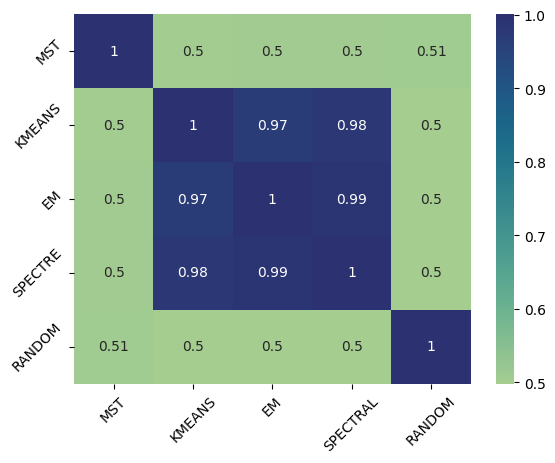

In [51]:
g = sns.heatmap(rand_idx_matrix, annot=True, xticklabels=["MST", "KMEANS", "EM", "SPECTRAL", "RANDOM"], yticklabels=["MST", "KMEANS", "EM", "SPECTRE", "RANDOM"], cmap="crest")
if g.get_yticklabels():
    g.set_yticklabels(labels=g.get_yticklabels(), rotation=45)
if g.get_xticklabels():
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

In [ ]:
mfn_rand = []

for k in range(0,1000):
    rpart = r_partition(2, 199)
    mfn_rand.append(nx.community.modularity(G, rpart))

In [41]:
for part, part_name in zip([clusters_mst, clusters_kmeans, clusters_em, clusters_spectral], ["MST", "KMEANS", "EM", "SPECTRAL"]):
    print(f"{part_name} clustering modularity value:", nx.community.modularity(G, part))
print("RANDOM clustering modularity value:", sum(mfn_rand)/1000)

MST clustering modularity value: 0.015237235489113599
KMEANS clustering modularity value: 0.05653391618453851
EM clustering modularity value: 0.05642951505083127
SPECTRAL clustering modularity value: 0.05650693207423946
RANDOM clustering modularity value: -0.0025225396775907273
